# Grover's Algorithm

This notebook serves to implement Grover's Algorithm in a Jupyter Notebook. Grover's Algorithm is known as the quantum search algorithm. It is used to find a unique input to a black box function that produces a particular output value, or set of output values. Here we are creating a two qubit algorithm, but higher level algorithms are possible.

## Physical Background

Grover's Algorithm, known as the "Quantum Search Algorithm", is exactly what its name entails: a search algorithm that utilizes the special rules of quantum mechanics to acheive its goal. Specifically, it is an unstructured search algorithm. This means that the database that it searches through does not need to be set up in a specific way.

Ordinarily, this kind of algorithm would take a classical computer $O(N)$ computations to complete. However, Grover's Algorithm takes only $O(\sqrt{N})$ computations. This is achieved through the use of superpositional states, a concept unique to quantum computers. To put this in perspective, if it would take a classical computer $10,000$, or $1 x 10^4$, computations to find the correct state, it would only take a quantum computer $100$, or $1 x 10^2$, computations. [1]

### Breakdown of the Algorithm

Grover's Algorithm is split into three main components. The first component is the intitial split into a superposition. This is what gives the algorithm its fast computation time, and it is accomplished on our circuit by a Hadamard gate on each qubit.

Following this is the Oracle matrix. The Oracle matrix serves to isolate the desired state, in our case this state is |11>. The way that this is accomplished is by the fact that the eigenvalue of the desired state is $-1$, while the eigenvalues of all other states is $1$. The oracle matrix then will assign a negative phase to the desired state, isolating it from the rest of the possible states. [1]

Next, the diffuser is applied. The diffuser serves to amplify the probability by rotating the superposition state closer to the desired state. One can represent this in a 2D plane with bases $|d>$, the desired state, and $|s'>$ the state perpendicular to the desired state. The superposition state $|s>$ is somewhere between these two in the plot. The Oracle matrix serves to reflec $|s>$ across the $s'$ axis, corresponding to the negative phase that it assigns. Then, the diffuser will reflect this new state across the original state much closer to $|d>$. Step-by-step, this process will bring the superposition state closer to the desired state, until it finally reaches it and is measured to obtain the correct result. [1]

## Implementation

Now that we know some of the physical background behind Grover's Algorithm, we can now make a simple example of it on a quantum circuit to later be run on one of IBM's open source quantum computers. 

First we are going to enable automatic linting to ensure the code is well written.

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

### Imports

First, we begin with a series of import statements. We need a number of general Python tools for plotting and analysis. We also need a number of tools from qiskit to create, run, and visualize our quantum circuit. 

In [2]:
# Python Tools

import matplotlib.pyplot as plt
import numpy as np
import time
import math

# Qiskit Tools

from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister
from qiskit import QuantumRegister, execute, transpile
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

In [3]:
# Set devices, if using a real device. Add your API key as a string into the save account argument
IBMQ.delete_account()
IBMQ.save_account()
IBMQ.load_account()

provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_belem')

3:80: E501 line too long (153 > 79 characters)


### Creating the Circuit

Now that the imports are complete, we want to initialize our quantum circuit. First, a few useful functions for creating our circuit elements are defined. We want to be able to inititalize our circuit, add an oracle matrix, and add a diffuser. It is also useful to have a function for repeatedly adding these circuit elements if we want to loop through the oracle matrix and diffuser. In this circuit, we want to make a state for the algorithm to recover. We begin by intitializing a two qubit circuit sent into a superposition by two Hadamard gates.

In [21]:
# Initialize a quantum circuit with a Hadamard Gate


def initial(Circ, Qubits):
    """Initializes the quantum circuit into a superposition
    with a Hadamard gate on each qubit. Takes a circuit and
    the qubits of the circuit as args.
    """
    for i in Qubits:
        Circ.h(i)
    return Circ


# Apply the oracle matrix to the circuit


def oracle(Circ, Qubits):
    """Applies the Oracle matrix to the quantum circuit.
    In our case, this is the controlled z gate onto each qubit.
    Takes a quantum circuit and the qubits of the circuit as args.
    """
    Circ.cz(Qubits[0], Qubits[1])
    return Circ


# Apply the diffuser to the matrix


def diffuse(Circ, Qubits):
    """Applies the diffuser onto the quantum circuit.
    In our case, this is a Hadamard, z , controlled z,
    and then another Hadamard gate in succession.
    Takes a quantum circuit and the qubits of the circuit as args.
    """
    for i in Qubits:
        Circ.h(i)
        Circ.z(i)
    oracle(Circ, Qubits)
    initial(Circ, Qubits)
    return Circ


# Apply the diffuser matrix a number of times equal to the Loops argument


def applyAmp(Circ, Qubits, Loops):
    """Applies the Oracle matrix and then the diffuser onto
    the quantum circuit a given number of times.
    Takes the loop count, a quantum circuit,
    and the qubits of the circuit as args."""
    for i in range(0, Loops):
        initial(Circ, Qubits)
        oracle(Circ, Qubits)
        diffuse(Circ, Qubits)
    return Circ


# Remove the measurement gates


def removeGates(Circ, num):
    """Removes a number of gates from the given quantum circuit
    equal to the number given"""
    for i in range(0, num):
        Circ.data.pop()

In [5]:
# Create and set up the intial circuit

qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
grover_circ = QuantumCircuit(qreg_q, creg_c)
qubits = [0, 1]

initial(grover_circ, qubits)

In [6]:
# Visualize the circuit

grover_circ.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘
c: 2/═════

### Applying the Oracle Matrix and the Diffuser

Now we need to add the components onto this circuit to make it function as a two qubit Grover's Algorithm. These components are the Oracle Matrix and the Diffuser. The Oracle matrix serves to select the state that we want from the possible states. The diffuser then amplifies the probability of this state. In our case, the Oracle matrix is a controlled z gate, while the diffuser is a Hadamard, z, controlled z, and then another Hadamard gate in succession. These gates will be applied to each qubit. [1]

In [7]:
# Create the CZ gate

oracle(grover_circ, qubits)

In [8]:
# Draw the Circuit

grover_circ.draw()

┌───┐   
q_0: ┤ H ├─■─
     ├───┤ │ 
q_1: ┤ H ├─■─
     └───┘   
c: 2/════════

In [9]:
# Apply the Diffuser

diffuse(grover_circ, qubits)

In [10]:
# Add Measurements

grover_circ.measure(qreg_q[0], creg_c[0])
grover_circ.measure(qreg_q[1], creg_c[1])

In [11]:
grover_circ.draw()

┌───┐   ┌───┐┌───┐   ┌───┐┌─┐   
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├┤M├───
     ├───┤ │ ├───┤├───┤ │ ├───┤└╥┘┌─┐
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├─╫─┤M├
     └───┘   └───┘└───┘   └───┘ ║ └╥┘
c: 2/═══════════════════════════╩══╩═
                                0  1

### Running the Circuit

Now that the circuit is properly set up, we can run it on a quantum computer. We use the tools and settings that we imported and initialized at the beginning of the notebook to now run this circuit on an IBM quantum computer 1024 times. This should give us a good idea of the actual results of the measurement.

In [12]:
# Execute and get counts

job = execute(grover_circ, backend=quito, shots=1024, optimization_level=3)
job_monitor(job, interval=2)

Job Status: job has successfully run


In [13]:
result = job.result()
counts = result.get_counts(grover_circ)
print(counts)

{'00': 11, '01': 65, '10': 42, '11': 906}


### Results

Here we can plot the results of our quantum circuit, and we see that the majority of the shots resulted in the correct measurement of 11. The other outcomes are due to external effects and noise which disrupts the quantum computer's accuracy. Given the fact that we ran this circuit 1024 times, we can see a clear trend. If we were to have run this fewer times, the results may have been less clear. Equally, this circuit can always be run a larger number of times in an attempt to validate the results further.

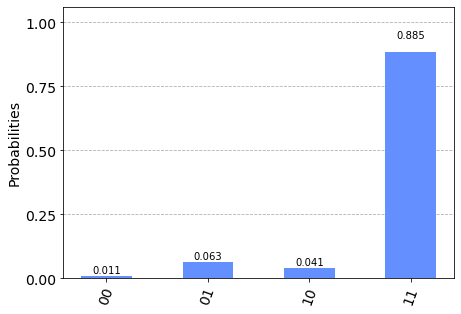

In [14]:
plot_histogram(counts)

### Multiple Runs

We can also utilize the previously defined function applyDiffuser to apply this circuit multiple times. This comes back to what was discussed in the physical background where the circuit may need to be run multiple times in order to reach the desired state. In our case, we only need one iteration of the circuit to obtain our desired result. First, we need to get rid of the measurement gates that we placed in before. We then will use a previously defined function to add the Amplifier (the Oracle matrix and the diffuser) a given number of times.

In [15]:
# Remove the measurement gates

removeGates(grover_circ, 2)

# Apply the Amplifier 2 times

applyAmp(grover_circ, qubits, 2)

### Visualization

We can then re-visualize the circuit here by drawing it again. One can notice that it is the first circuit repeated three times. Each time it is initialized, the Oracle matrix is applied, and the diffuser is applied. We then add back on the measurement gates so that we can obtain the data from this circuit.

In [16]:
grover_circ.draw()

┌───┐   ┌───┐┌───┐   ┌───┐┌───┐   ┌───┐┌───┐   ┌───┐┌───┐   ┌───┐┌───┐   »
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├┤ H ├─■─┤ H ├┤ Z ├─■─»
     ├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ »
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├┤ H ├─■─┤ H ├┤ Z ├─■─»
     └───┘   └───┘└───┘   └───┘└───┘   └───┘└───┘   └───┘└───┘   └───┘└───┘   »
c: 2/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«     ┌───┐
«q_0: ┤ H ├
«     ├───┤
«q_1: ┤ H ├
«     └───┘
«c: 2/═════
«

In [17]:
# Add Measurements

grover_circ.measure(qreg_q[0], creg_c[0])
grover_circ.measure(qreg_q[1], creg_c[1])

### Running the Circuit and Results

We can now run and visualize the results of the circuit the same way that we did before. Remember, this circuit is trying to search for the |11> state, so we are expecting to find that state the majority of the times we run the circuit.

In [18]:
# Execute and get counts

job2 = execute(grover_circ, backend=quito, shots=1024, optimization_level=3)
job_monitor(job2, interval=2)

Job Status: job has successfully run


In [19]:
result2 = job2.result()
counts2 = result2.get_counts(grover_circ)
print(counts2)

{'00': 6, '01': 43, '10': 55, '11': 920}


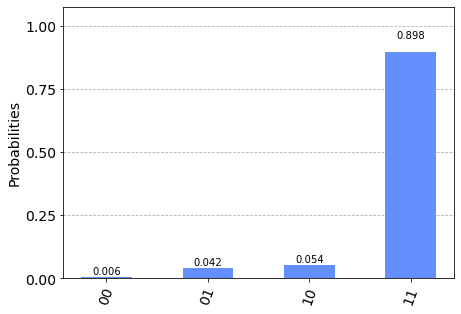

In [20]:
plot_histogram(counts2)

## Summary and Further Reading

We see from this histogram that we did in fact find the desired state, and it was slightly more accurate than before. As mentioned previously, this is not entirely reliable because of the decoherence effects faced by quantum computers. However, this does show the general process that a Grover's Algorithm proceeds through during its search. The steps are clearly broken down into their circuit elements, and the results show the desirable outcome was achieved.

This same concept can be applied to broader and more interesting topics. One example of this is found in a paper listed here: https://arxiv.org/abs/2010.00649. This High Energy Experimental group working with data from the ATLAS group and the LHC is using Grover's Algorithm to search for rare instances of Higgs Boson production from 4 lepton events. The data sets released from ATLAS are unstructured, and so this group thought to use Grover's Algorithm to better search for the desired production events. Their implementation is also through a Jupyter Notebook, and so it will hopefully be easier to understand after reviewing our much more basic example. [2]

### References:

[1] https://qiskit.org/textbook/ch-algorithms/grover.html

[2] https://arxiv.org/abs/2010.00649